In [2]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import csv
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn import preprocessing

plt.ioff()
pd.set_option('display.max_columns', None)

## Download data from https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset

In [3]:
data_frame = pd.read_csv('data/2_2.csv')

In [4]:
data_frame.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [5]:
# helper method for categorical feature processing
def categorize_columns(data_frame, keys_to_catorize):
    headers = data_frame.columns.tolist()
    for header in headers:
        if header not in keys_to_catorize:
            continue
        one_hot = pd.get_dummies(data_frame[header], prefix=header)
        data_frame = data_frame.drop(header, axis=1)
        data_frame = data_frame.join(one_hot)
    return data_frame

In [6]:
# process data into features

keys_to_keep = ['budget', 'duration', 'facenumber_in_poster', 'imdb_score', 'title_year']
keys_to_drop = [k for k in data_frame.keys() if k not in keys_to_keep]
keys_to_catorize = ['content_rating', 'country']

data_frame = categorize_columns(data_frame, keys_to_catorize)
data_frame = data_frame.fillna(0.0)
keys_to_drop = [k for k in keys_to_drop if k in data_frame.keys()]
trimmed_data_frame = data_frame.drop(keys_to_drop, axis=1)
features = np.array(trimmed_data_frame)
genres = list(data_frame['genres'])
durations = list(data_frame['duration'])
features = preprocessing.scale(features)

Y = []
X = []
genre_map = {}
for i in range(len(genres)):
    genre = genres[i]
    x = features[i,:]
    g_rep = None
    genre_map[genre] = genre_map.get(genre, 0) + 1
    if 'Horror' in genre:
        g_rep = 0
    elif 'Action' in genre:
        g_rep = 1
    elif 'Romance' in genre:
        g_rep = 2
    elif 'Family' in genre:
        g_rep = 3
    if g_rep is not None and durations[i] > 1.0:
        X.append(x)
        Y.append(g_rep)

X = np.array(X)
Y = np.array(Y)

In [7]:
pd.DataFrame(Y, dtype="category").describe()

,0
count,2986
unique,4
top,1
freq,1062


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/4., random_state=0)
print(X_train.shape)
print(Y_train.shape)

(2239, 88)
(2239,)


In [9]:
svm_model = svm.SVC(kernel='rbf', C=1.0)
svm_model.fit(X_train, Y_train)

Y_train_pred = svm_model.predict(X_train)
Y_test_pred = svm_model.predict(X_test)

train_mse = sklearn.metrics.mean_squared_error(Y_train, Y_train_pred)
test_mse = sklearn.metrics.mean_squared_error(Y_test, Y_test_pred)
print("Train MSE {}".format(train_mse))
print("Test MSE {}".format(test_mse))

train_accuracy = sklearn.metrics.accuracy_score(Y_train, Y_train_pred)
test_accuracy = sklearn.metrics.accuracy_score(Y_test, Y_test_pred)
print("Train Accuracy {}%".format(train_accuracy*100.0))
print("Test Accuracy {}%".format(test_accuracy*100))

Train MSE 0.825368468066
Test MSE 1.01472556894
Train Accuracy 59.4908441268%
Test Accuracy 52.4765729585%


In [10]:
svm_model.predict(X[:2,:])

array([1, 1])

In [11]:
cf_matrix = confusion_matrix(Y_test, Y_test_pred)

Confusion matrix, without normalization
[[ 64  32  34   7]
 [ 30 124  72  37]
 [ 35  57 129  34]
 [  1   7   9  75]]


<IPython.core.display.Javascript object>


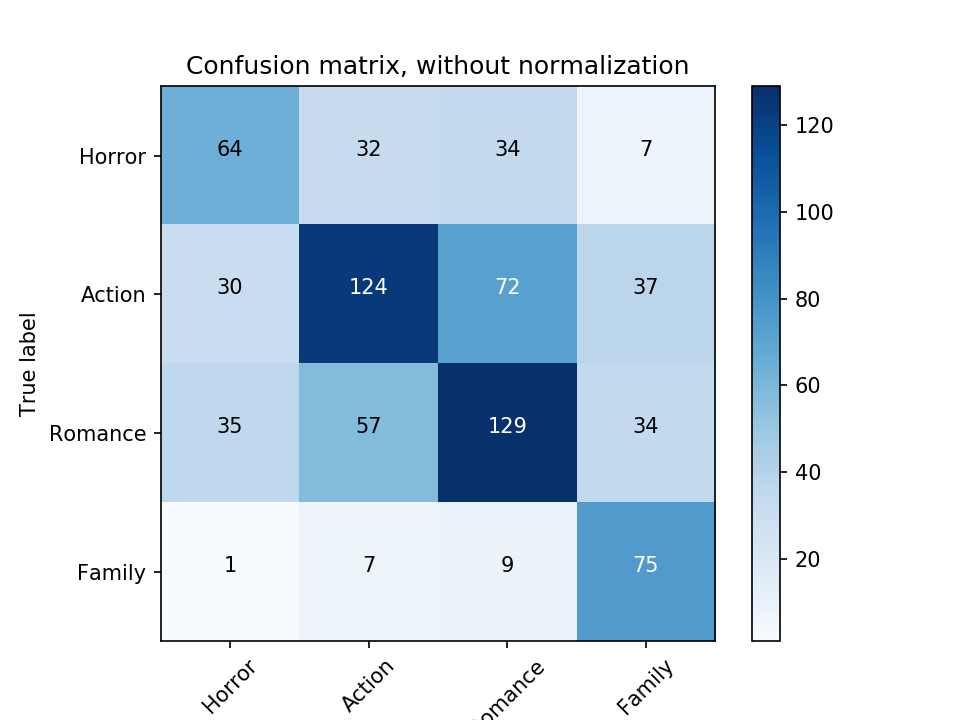

In [12]:
# adapted from:
# https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(cf_matrix, classes=["Horror", "Action", "Romance", "Family"],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.46715328  0.23357664  0.24817518  0.05109489]
 [ 0.11406844  0.47148289  0.27376426  0.14068441]
 [ 0.1372549   0.22352941  0.50588235  0.13333333]
 [ 0.01086957  0.07608696  0.09782609  0.81521739]]


<IPython.core.display.Javascript object>


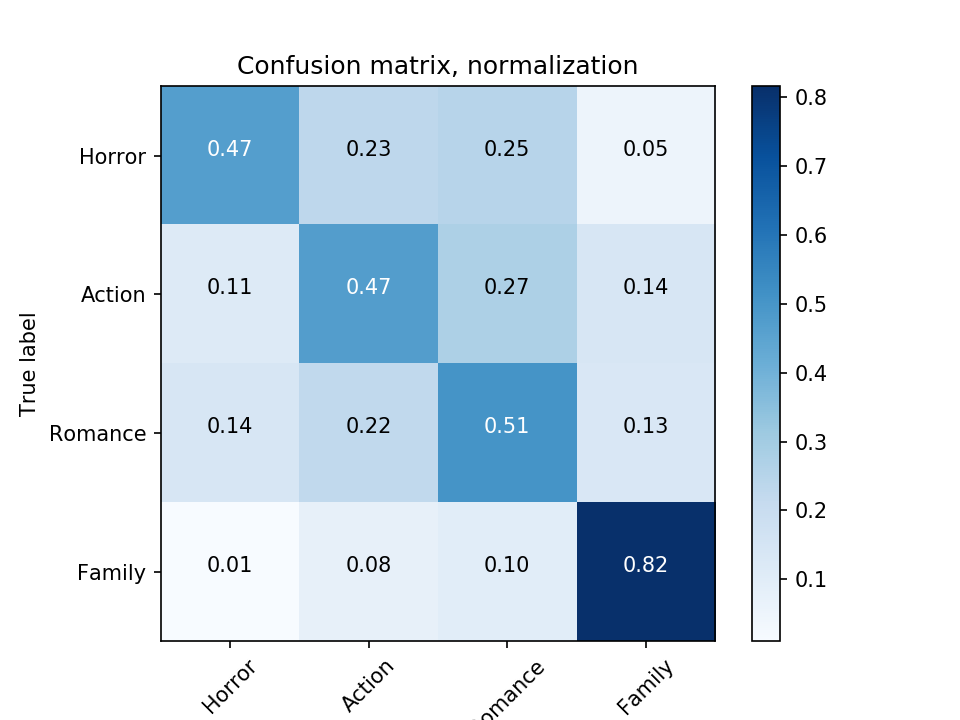

In [13]:
plot_confusion_matrix(cf_matrix, classes=["Horror", "Action", "Romance", "Family"],
                      title='Confusion matrix, normalization', normalize=True)
plt.show()